# GFER with antibodies analysis with improved Cox17 data analysis
_Maydan Wienreb_
<img src="https://raw.githubusercontent.com/maydanw/InEasyReach/master/hr-brian-litzinger-one.png" alt="Drawing" style="width: 100%; height: 60px" />

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports

In [2]:
"""
This will enable completion on elements of lists, results of function calls, etc.
However, be warned that enabling this option can be unsafe, because the code is actually evaluated upon hitting TAB
"""
%config IPCompleter.greedy=True

from typing import Dict, Tuple, List

# import numpy
import numpy as np
np.random.seed(0) # Remmeber to reset the seed every time if you expect the second draw to be the same as the first.

#import pandas
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# import graphics
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import rcParams


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# %load_ext autoreload
# %autoreload 1
# %aimport TestFunctions
## See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html


In [9]:
rcParams['figure.figsize'] = [12.0, 8.0]
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

# Do run in the first time: jupyter nbextension enable --py --sys-prefix widgetsnbextension

Loading BokehJS ...

In [4]:
import types
import sys
print ("Basic packages versions:")
print ("   Python version: %s" % (sys.version))
print ("   Packages:")


try:  
    g=globals().values()
    for i, mod in enumerate(g):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__') and hasattr(mod, '__version__'):
                print ("   %s: %s" % (mod.__name__, mod.__version__))
except: 
    g=globals().values()
    for i, mod in enumerate(g):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__') and hasattr(mod, '__version__'):
                print ("   %s: %s" % (mod.__name__, mod.__version__))

Basic packages versions:
   Python version: 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
   Packages:
   json: 2.0.9
   numpy: 1.15.0
   pandas: 0.23.3
   seaborn: 0.9.0


# General

In [10]:
patients = {"AV": {'age': 6*4, "gender": "M", "color": "cornflowerblue"}, 
            "EV": {"age": 5.5*12*4, "gender": "F", "color": "violet"},
            "HC CM": {"age": 6*12*4, "gender": "F", "color": "green"},
            "AG044": {"age": 15, "gender": "F", "color": "limegreen"},
            "AG015": {"age": 3/7, "gender": "M", "color": "cyan"},
            "HV": {"age": 37*12*4, "gender": "F", "color": "darkviolet"},
            "MV": {"age": 36.5*12*4, "gender": "M", "color": "royalblue"},
            "HC IK": {"age": 32*12*4, "gender": "F", "color": "gray"},
            "HC OZ": {"age": 35*12*4, "gender": "M", "color": "yellow"},
            "HC NA0730":{"age": 53*12*4, "gender": "M", "color": "coral"}}
patients_df = pd.DataFrame(patients).T
patients_df


age           color gender
AV               24  cornflowerblue      M
EV              264          violet      F
HC CM           288           green      F
AG044            15       limegreen      F
AG015      0.428571            cyan      M
HV             1776      darkviolet      F
MV             1752       royalblue      M
HC IK          1536            gray      F
HC OZ          1680          yellow      M
HC NA0730      2544           coral      M

In [11]:
from scipy.stats import mannwhitneyu

def compare_results(df, base_key, feature_name, df_grpby_key='Pcol', hyp_alternative="less"):
    df_grp_row = df.groupby(df_grpby_key)
    base_data = df_grp_row[feature_name].get_group(base_key)

    p_values = {}
    for grp_k in df_grp_row[feature_name].groups.keys():
        if grp_k==base_key:
            continue
        p_data = df_grp_row[feature_name].get_group(grp_k)
        stat, p = mannwhitneyu(base_data, p_data, alternative=hyp_alternative)
        p_values[grp_k] = p
    return p_values

In [12]:
def pval_corrected(pvals_raw, method=None):
    '''p-values corrected for multiple testing problem
 
    This uses the default p-value correction of the instance stored in
    ``self.multitest_method`` if method is None.
 
    '''
    import statsmodels.stats.multitest as smt
    if method is None:
        method = 'Bonferroni'
    #TODO: breaks with method=None
    return smt.multipletests(pvals_raw, method=method)[1]

In [13]:
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource, CategoricalColorMapper, LabelSet
from bokeh.palettes import Set3
from bokeh.palettes import d3
from bokeh.models.tools import HoverTool
from bokeh.models import NumeralTickFormatter


def plot_column(df, column_name, agg='50%'):

    TOOLS='pan,wheel_zoom,box_zoom,reset'

    source = ColumnDataSource(df)
    patients_names =  source.data['Pcol'].tolist()
    plot_options = dict(width=750, plot_height=350,tools=TOOLS)
    p = figure(**plot_options, x_range=patients_names)


    # palette = d3['Category10'][len(patients_names)]
    # palette = [patients[pn]['color'] for pn in patients_names]
    # color_map = CategoricalColorMapper(factors=patients_names, palette=palette)
    
    source.data['color'] = [patients[pn]['color'] for pn in patients_names]
    source.data['age'] = [patients[pn]['age']/4/12 for pn in patients_names]
    source.data['gender'] = [patients[pn]['gender'] for pn in patients_names]
    
    cell_count = df["Pcol"].count().to_dict()
    source.data['cell_count'] = [cell_count[pn] for pn in patients_names]

    # renderer = p.vbar(x='Pcol', top='Cox17 IxA_50%', width=0.95, line_color="gray", source=source, color={'field': 'Pcol', 'transform': color_map})
    renderer = p.vbar(x='Pcol', top=f"{column_name}_{agg}", width=0.95, line_color="gray", source=source, color='color')
    
    source.data[f"formatted_{column_name}_{agg}"] = [f"{x:,.4f}" if x<10 else f"{x:,.0f}" for x in source.data[f"{column_name}_{agg}"]]
    labels = LabelSet(x='Pcol', y=f"{column_name}_{agg}", text=f"formatted_{column_name}_{agg}", level='glyph',
        x_offset=-30, y_offset=0, source=source, render_mode='canvas')
    p.add_layout(labels)

    p.add_tools(HoverTool(tooltips= [("Name", "@Pcol"), ("Age", "@age"), ("Gender", "@gender"), ("Cell count", "@cell_count")], renderers=[renderer], mode='mouse'))
    p.yaxis[0].formatter = NumeralTickFormatter(format="0,0.00")

    show(p)

# Cox 17

## Loading Data

In [14]:
data_path = ".\\Data\\20181120\\Cox17-new.xls"

In [15]:
# read the data from the file
df_cox17 = pd.read_excel(data_path, header=1)

# remove redundent column
df_cox17.drop("Target Set",axis=1, inplace=True)

# rename columns
df_cox17.columns = df_cox17.columns.str.replace("Mitochondrial", "Cox17")
df_cox17.rename({"cox total int": "Cox17 total intensity"}, axis="columns", inplace=True)

# extract the positional data 
loc_df = df_cox17.Section.str.extract("(.*) - (.*) \(fld (.*)\).*",expand=True)
loc_df.columns=["Prow","Pcol", "Pfield"]
loc_df.Pcol = loc_df.Pcol.astype(np.int16)
df_cox17 = df_cox17.join(loc_df)
df_cox17.drop("Section",axis=1, inplace=True)

# replace rows with patients names and join patients data
df_cox17.Pcol.replace([2,3,4,5,6,7,8,9,10,11], 
                ["AV", "HC CM", "EV", "AG044", "HV", "AG015", "HC IK", "MV", "HC OZ", "HC NA0730"],
               inplace=True)
df_cox17 = df_cox17.join(patients_df, on='Pcol')

df_cox17.sample(7)

Target  Nuclear area  Nuclear perimeter  Nuclear IxA  Nuclear intensity  Nuclear 1/form factor Cell cycle Toxicity status  Cox17 total intensity  Cox17 count  Cox17 mean area  Cox17 mean intensity  Cox17 total area    Cox17 IxA     Cell status  Cell area  Cell length  Cell perimeter  Cell 1/form factor  Cell intensity      Cell IxA Prow       Pcol Pfield   age           color gender
619        5       162.242             46.149   438359.832           2701.882                  0.957  G2M phase  Early toxicity             193926.470           84            2.861              2692.898           240.300   647104.686  Early toxicity   1253.576       87.228         250.102               0.252        3107.141  3.895038e+06    C         EV      8   264          violet      F
2102       8       221.499             55.667   505201.390           2280.830                  0.898  G2M phase  Early toxicity             283017.275          127            0.792              2480.451           100.557   249425.454  Early toxicity  20360.052      258.617        1039.391               0.237        1157.195  2.356055e+07    C         MV      8  1752       royalblue      M
195       13       252.236             58.662   621628.293           2464.468                  0.921  G2M phase  Early toxicity              50088.888           24            1.844              2210.033            44.258    97810.640  Early toxicity   1973.950       74.361         316.855               0.247        2657.930  5.246620e+06    C         AV     15    24  cornflowerblue      M
1157      17       210.514             54.264   486584.916           2311.416                  0.898  G2M phase  Early toxicity             158577.052           71            1.049              2592.305            74.467   193040.505  Early toxicity   2388.006      243.961         581.826               0.089        3229.009  7.710893e+06    C         HV      3  1776      darkviolet      F
2677       6       160.869             46.857   629069.369           3910.438                  0.921  G2M phase  Early toxicity              84322.690           39            0.980              2436.351            38.237    93158.317  Early toxicity   4753.091      123.926         455.734               0.288        1870.303  8.889718e+06    C  HC NA0730     10  2544           coral      M
2272      12       244.842             56.862   537661.813           2195.950                  0.952  G2M phase  Early toxicity             399655.069          173            3.040              3141.663           525.915  1652246.946  Early toxicity   3739.815      191.720         852.156               0.065        5023.606  1.878735e+07    C      HC OZ      3  1680          yellow      M
1290       6       203.014             85.667    58306.086            287.202                  0.348    S phase  Early toxicity             189863.851           86            0.421              2389.300            36.230    86564.155  Early toxicity   3349.630      148.280         462.479               0.197        1932.039  6.471615e+06    C         HV     10  1776      darkviolet      F

In [16]:
df_cox17.describe()

Target  Nuclear area  Nuclear perimeter   Nuclear IxA  Nuclear intensity  Nuclear 1/form factor  Cox17 total intensity  Cox17 count  Cox17 mean area  Cox17 mean intensity  Cox17 total area     Cox17 IxA     Cell area  Cell length  Cell perimeter  Cell 1/form factor  Cell intensity      Cell IxA
count  2833.000000   2833.000000        2833.000000  2.833000e+03        2833.000000            2833.000000           2.833000e+03  2833.000000      2833.000000           2833.000000       2833.000000  2.833000e+03   2833.000000  2833.000000     2833.000000         2833.000000     2833.000000  2.833000e+03
mean      8.743029    222.877126          56.148766  5.265105e+05        2340.865476               0.887068           2.272771e+05   100.903283         3.173373           2762.485082        263.022497  7.655977e+05   3637.200576   139.996454      506.813976            0.228541     3263.706332  1.076866e+07
std       5.685586     45.343665           6.821606  7.734336e+05        1116.883556               0.074612           1.556764e+05    67.782698         3.201092           1020.915429        192.543938  6.627150e+05   2909.839403    57.927066      291.259321            0.146962      974.564414  6.845716e+06
min       1.000000    102.141000          37.024000  0.000000e+00           0.000000               0.251000           2.222500e+03     1.000000         0.132000           2045.300000          0.211000  4.695100e+02   1000.073000    41.746000      124.228000            0.005000      580.826000  1.035477e+06
25%       4.000000    197.416000          52.451000  4.399984e+05        1918.781000               0.861000           1.275838e+05    57.000000         1.209000           2489.433000        106.577000  2.721024e+05   1870.330000    96.173000      313.508000            0.112000     2646.824000  6.153887e+06
50%       8.000000    219.598000          55.574000  4.847333e+05        2216.373000               0.902000           1.922630e+05    86.000000         2.154000           2664.667000        229.632000  6.270320e+05   2763.508000   131.342000      454.539000            0.187000     3165.837000  8.951516e+06
75%      13.000000    244.209000          58.988000  5.420625e+05        2601.635000               0.935000           2.880794e+05   128.000000         4.067000           2886.878000        376.453000  1.086915e+06   4279.039000   173.959000      628.981000            0.315000     3755.766000  1.340853e+07
max      30.000000    958.773000         174.514000  3.092511e+07       35251.080000               0.987000           2.242823e+06   940.000000        63.672000          49967.128000       1392.475000  8.681259e+06  20875.510000   428.171000     6503.115000            0.864000     7990.693000  6.119585e+07

In [17]:
df_cox17["Pcol"].value_counts().plot(kind='bar')

<div class="alert alert-warning" role="warning">
  Do note, the number of cells is not identical. <BR> Is this difference OK?
</div>

## Group by patient


In [18]:
df_cox17["Cox17 area ratio*"] = df_cox17['Cox17 total area']/df_cox17['Cell area']
df_cox17["Cox17 total intensity ratio*"] = df_cox17["Cox17 total intensity"]/df_cox17['Cell intensity']
df_cox17["Cox17 IxA ratio*"] = df_cox17["Cox17 IxA"]/df_cox17['Cell IxA']

In [19]:
cox17_features = df_cox17.columns[df_cox17.columns.str.contains("Cox17")].tolist()
cox17_features.remove('Cox17 count')
cox17_features.remove('Cox17 mean area')
cox17_features.remove('Cox17 mean intensity')

In [20]:
df_grp_row = df_cox17.groupby("Pcol")

cox17_medians = df_grp_row[cox17_features].median()
display(cox17_medians)

Cox17 total intensity  Cox17 total area    Cox17 IxA  Cox17 area ratio*  Cox17 total intensity ratio*  Cox17 IxA ratio*
Pcol                                                                                                                              
AG015                152385.0030          281.2835  785575.2230           0.121222                     43.215614          0.089516
AG044                155115.1600          315.0840  896816.4415           0.132265                     40.514650          0.094536
AV                   176660.1420          163.4040  405335.3630           0.055921                     60.588367          0.050118
EV                   171251.1030          183.6850  472414.0540           0.061214                     56.385336          0.051701
HC CM                164643.1390          334.2030  958068.5050           0.170517                     53.183452          0.149413
HC IK                211694.4275          251.8670  680208.3745           0.061329                     67.344798          0.055735
HC NA0730            264205.0865          197.7330  548352.2795           0.047452                    100.555021          0.048911
HC OZ                234333.9980          251.0745  715685.1225           0.070029                     81.713722          0.064132
HV                   200795.8490          264.7000  725584.6045           0.078095                     63.029654          0.067719
MV                   228468.1170          204.2820  542793.8390           0.048956                     80.792696          0.045783

In [21]:
plot_column(df_grp_row, 'Cox17 total area')

In [22]:
plot_column(df_grp_row, 'Cox17 total intensity')

In [23]:
plot_column(df_grp_row, 'Cox17 area ratio*')

In [24]:
plot_column(df_grp_row, 'Cox17 IxA ratio*')

In [25]:
plot_column(df_grp_row, 'Cox17 IxA')

## Cox17 total area
Cox17 total area seems to be correlated with the cell area

In [31]:
display(df_cox17[["Cox17 total area", "Cell area"]].corr())

from matplotlib.lines import Line2D
lgn = [Line2D([0], [0], color=p['color'], lw=2, label='Line') for p in patients.values()]
plt.scatter(x=df_cox17["Cox17 total area"], y=df_cox17["Cell area"], c=df_cox17["Pcol"].apply(lambda x: patients[x]['color']), alpha=0.85)
plt.legend(lgn, patients.keys())

Cox17 total area  Cell area
Cox17 total area          1.000000   0.313494
Cell area                 0.313494   1.000000

Some correlation exists but it is not strong as the the variance is huge

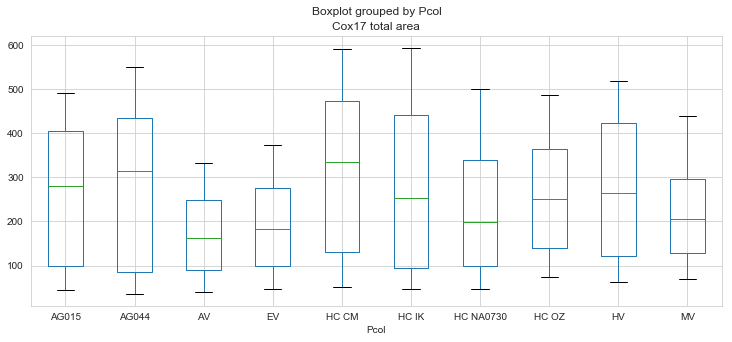

In [32]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 total area",by="Pcol", ax=ax, showfliers=False, whis=[10,90] )
plt.show()

In [33]:
p_values = compare_results(df_cox17, 'AV', 'Cox17 total area')

In [34]:
print("Cox17 total area - p values:\n"+"-"*35)
for k,v in p_values.items():
    print(f'{k}:\t\t {v:.6f}')

Cox17 total area - p values:
-----------------------------------
AG015:		 0.000000
AG044:		 0.000000
EV:		 0.040197
HC CM:		 0.000000
HC IK:		 0.000000
HC NA0730:		 0.000242
HC OZ:		 0.000000
HV:		 0.000000
MV:		 0.000159


In [35]:
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 total area - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 total area - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
EV:		 0.361770
HC CM:		 0.000000
HC IK:		 0.000004
HC NA0730:		 0.002175
HC OZ:		 0.000000
HV:		 0.000000
MV:		 0.001430


<div class="alert alert-info" role="alert">
  Alon is significantly less then everybody expect Ella
</div>

In [36]:
p_values = compare_results(df_cox17, 'EV', 'Cox17 total area')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 total area - p values:\n"+"-"*35)
for k,v in p_values.items():
    print(f'{k}:\t\t {v:.6f}')
print("\n")
print("Cox17 total area - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 total area - p values:
-----------------------------------
AG015:		 0.000000
AG044:		 0.000000
AV:		 0.959844
HC CM:		 0.000000
HC IK:		 0.000011
HC NA0730:		 0.008062
HC OZ:		 0.000000
HV:		 0.000000
MV:		 0.015290


Cox17 total area - adjusted p values:
----------------------------------------
AG015:		 0.000001
AG044:		 0.000000
AV:		 1.000000
HC CM:		 0.000000
HC IK:		 0.000099
HC NA0730:		 0.072556
HC OZ:		 0.000000
HV:		 0.000000
MV:		 0.137608


<div class="alert alert-info" role="alert">
  Ella is significantly less then all the children (expect Alon) and some of the adults. With the Bonferroni correction all 
</div>

In [37]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 total area"].get_group('AV'), kde=False,bins=range(0, 700, 25), ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 total area"].get_group('EV'), kde=False, bins=range(0, 700, 25) ,ax=ax, color='r')
ax.legend(['AV','EV'])

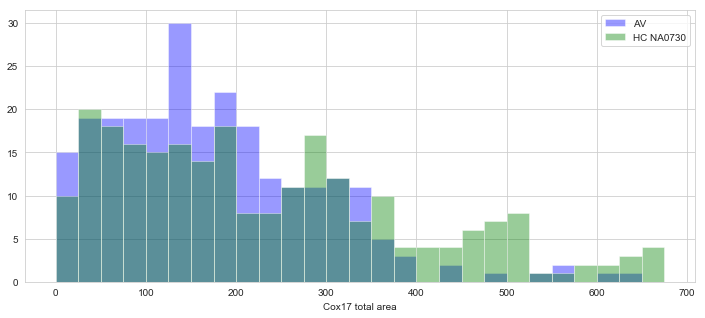

In [38]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 total area"].get_group('AV'), kde=False, bins=range(0, 700, 25), ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 total area"].get_group('HC NA0730'), kde=False, bins=range(0, 700, 25) ,ax=ax, color='g')
ax.legend(['AV','HC NA0730'])

## Cox 17 - Cell area

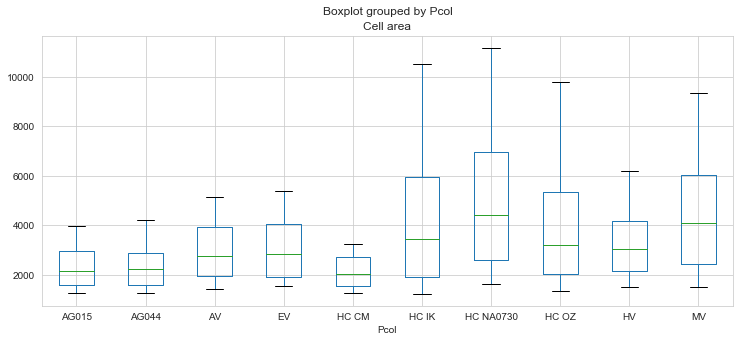

In [39]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cell area",by="Pcol", ax=ax, showfliers=False,whis=[10,90])
plt.show()

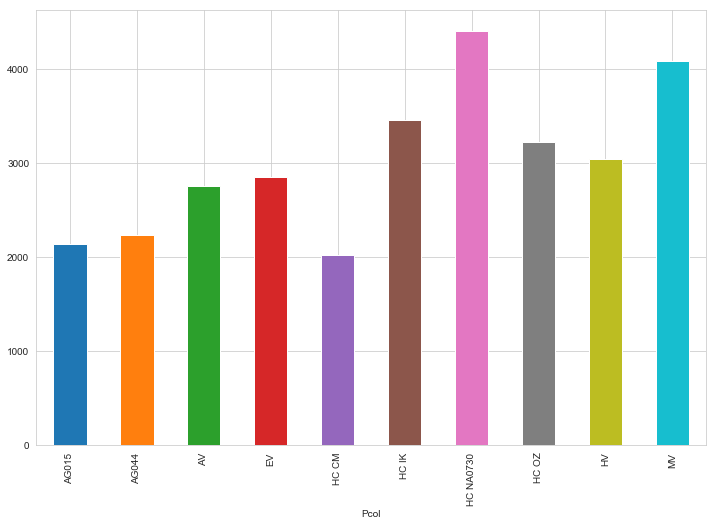

In [40]:
df_grp_row["Cell area"].median().plot(kind='bar')

In [41]:
p_values = compare_results(df_cox17, 'AV', 'Cell area', hyp_alternative='greater')

In [42]:
print("Cell area - p values:\n"+"-"*35)
for k,v in p_values.items():
    print(f'{k}:\t\t {v:.6f}')

Cell area - p values:
-----------------------------------
AG015:		 0.000000
AG044:		 0.000000
EV:		 0.725286
HC CM:		 0.000000
HC IK:		 0.999795
HC NA0730:		 1.000000
HC OZ:		 0.999754
HV:		 0.980380
MV:		 1.000000


In [43]:
corrected_pval = pval_corrected(list(p_values.values()))
print("Cell area - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cell area - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000002
EV:		 1.000000
HC CM:		 0.000000
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 1.000000
HV:		 1.000000
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Alon cell area is significantly larger then the other children (except Ella)
</div>

## Cox17 area ratio*

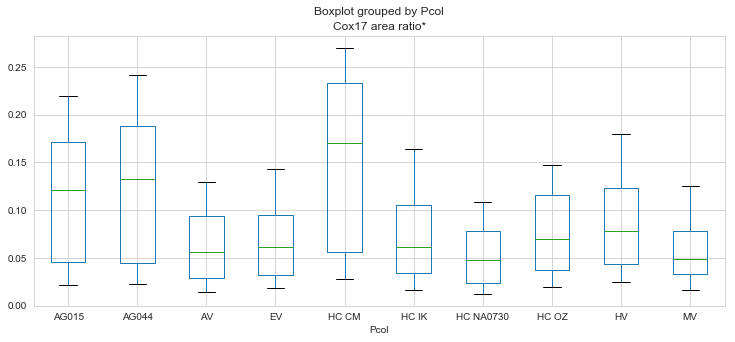

In [44]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 area ratio*",by="Pcol", ax=ax, showfliers=False, whis=[10,90])
plt.show()

Pcol
AG015        0.121222
AG044        0.132265
AV           0.055921
EV           0.061214
HC CM        0.170517
HC IK        0.061329
HC NA0730    0.047452
HC OZ        0.070029
HV           0.078095
MV           0.048956
Name: Cox17 area ratio*, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028E6CA58CF8>]],
      dtype=object)

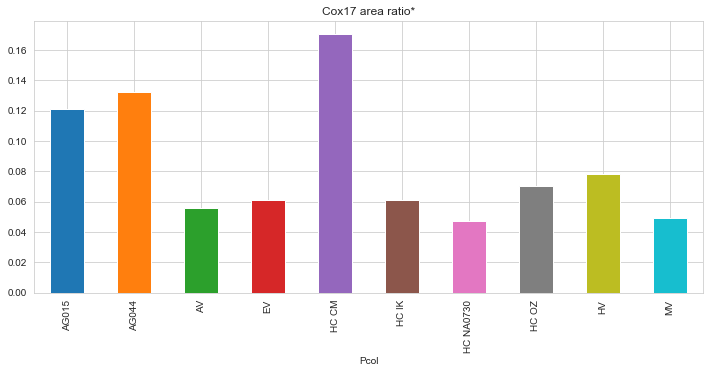

In [45]:
cox17_medians = df_grp_row["Cox17 area ratio*"].median()
display(cox17_medians)


# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)
# Set title
cox17_medians.plot(kind='bar', ax=ax, subplots=True, layout=(1,1))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


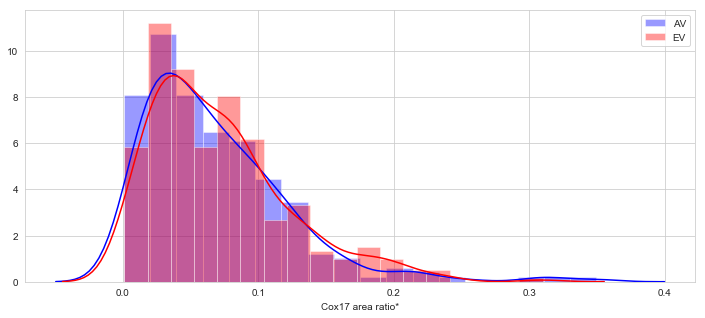

In [46]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 area ratio*"].get_group('AV'), kde=True, ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 area ratio*"].get_group('EV'), kde=True ,ax=ax, color='r')
ax.legend(['AV','EV'])

In [47]:
p_values = compare_results(df_cox17, 'AV', 'Cox17 area ratio*')

In [48]:
print("Cox17 area ratio* - p values:\n"+"-"*35)
for k,v in p_values.items():
    print(f'{k}:\t\t {v:.6f}')

Cox17 area ratio* - p values:
-----------------------------------
AG015:		 0.000000
AG044:		 0.000000
EV:		 0.166809
HC CM:		 0.000000
HC IK:		 0.033867
HC NA0730:		 0.990878
HC OZ:		 0.001138
HV:		 0.000001
MV:		 0.846094


In [49]:
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 area ratio* - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 area ratio* - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
EV:		 1.000000
HC CM:		 0.000000
HC IK:		 0.304803
HC NA0730:		 1.000000
HC OZ:		 0.010244
HV:		 0.000008
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Alon Cox17 area ratio is significantly less then the other children (except Ella)
</div>

In [50]:
p_values = compare_results(df_cox17, 'EV', 'Cox17 area ratio*')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 area ratio* - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 area ratio* - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
AV:		 1.000000
HC CM:		 0.000000
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 0.116553
HV:		 0.000118
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Ella Cox17 area ratio is significantly less then the other children (except Alon)
</div>

## Cox17 IxA ratio*

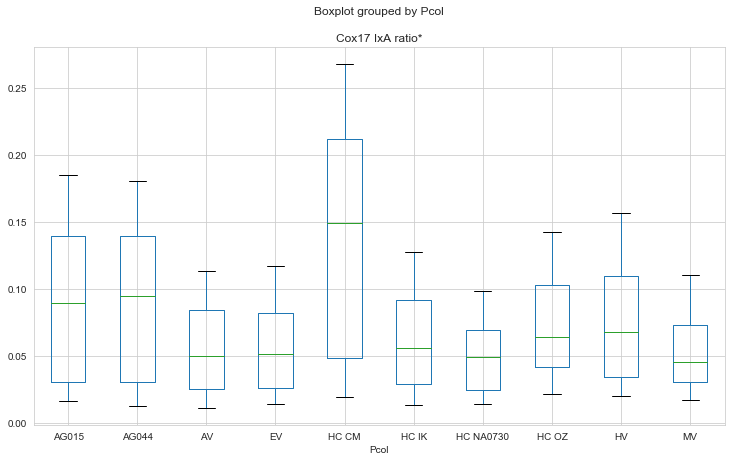

In [51]:
# Create a figure of given size
fig = plt.figure(figsize=(12,7))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 IxA ratio*",by="Pcol", ax=ax, showfliers=False, whis=[10,90])
plt.show()

Pcol
AG015        0.089516
AG044        0.094536
AV           0.050118
EV           0.051701
HC CM        0.149413
HC IK        0.055735
HC NA0730    0.048911
HC OZ        0.064132
HV           0.067719
MV           0.045783
Name: Cox17 IxA ratio*, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028E6CB42438>]],
      dtype=object)

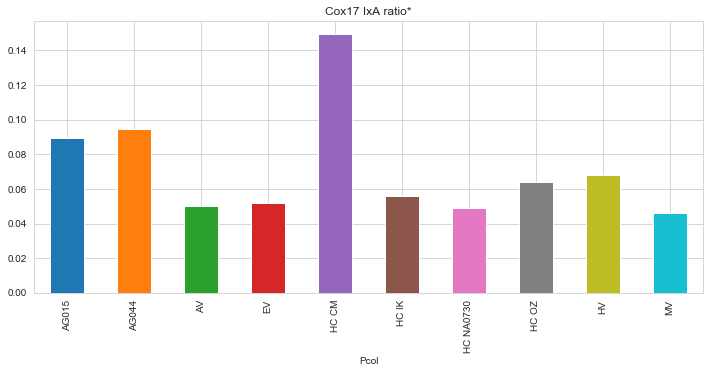

In [52]:
cox17_medians = df_grp_row["Cox17 IxA ratio*"].median()
display(cox17_medians)


# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)
# Set title
cox17_medians.plot(kind='bar', ax=ax, subplots=True, layout=(1,1))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


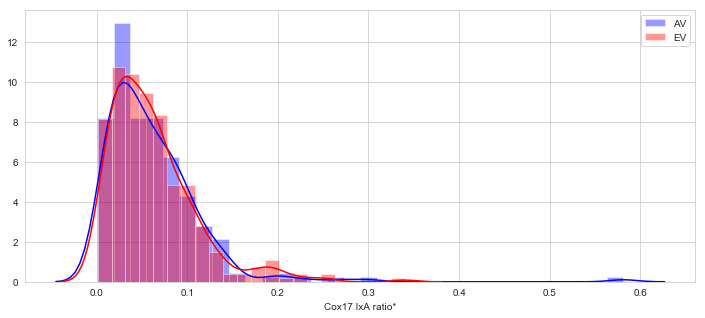

In [53]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_row["Cox17 IxA ratio*"].get_group('AV'), kde=True, ax=ax, color='b')
sns.distplot(df_grp_row["Cox17 IxA ratio*"].get_group('EV'), kde=True ,ax=ax, color='r')
ax.legend(['AV','EV'])

In [54]:
p_values = compare_results(df_cox17, 'AV', 'Cox17 IxA ratio*')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 IxA ratio* - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 IxA ratio* - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
EV:		 1.000000
HC CM:		 0.000000
HC IK:		 0.724954
HC NA0730:		 1.000000
HC OZ:		 0.000043
HV:		 0.000033
MV:		 1.000000


In [55]:
p_values = compare_results(df_cox17, 'EV', 'Cox17 IxA ratio*')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 IxA ratio* - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 IxA ratio* - adjusted p values:
----------------------------------------
AG015:		 0.000000
AG044:		 0.000000
AV:		 1.000000
HC CM:		 0.000000
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 0.000033
HV:		 0.000030
MV:		 1.000000


Does AG044 is significantly different from HC CM?

In [56]:
p_values = compare_results(df_cox17, 'AG044', 'Cox17 IxA ratio*')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cox17 IxA ratio* - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cox17 IxA ratio* - adjusted p values:
----------------------------------------
AG015:		 1.000000
AV:		 1.000000
EV:		 1.000000
HC CM:		 0.000000
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 1.000000
HV:		 1.000000
MV:		 1.000000


AG044 - HC CM is the only significant difference he have.

# GFER

## Loading data

In [57]:
data_path = ".\\Data\\20181120\\GFER-new.xls"

In [58]:
df_gfer = pd.read_excel(data_path, header=1)

df_gfer.drop("Target Set",axis=1, inplace=True)
df_gfer.columns = df_gfer.columns.str.replace("Mitochondrial", "GFER")
loc_df = df_gfer.Section.str.extract("(.*) - (.*) \(fld (.*)\).*",expand=True)
loc_df.columns=["Prow","Pcol", "Pfield"]
loc_df.Pcol = loc_df.Pcol.astype(np.int16)
df_gfer = df_gfer.join(loc_df)
df_gfer.drop("Section",axis=1, inplace=True)
df_gfer.Pcol.replace([2,3,4,5,6,7,8,9,10,11], 
                ["AV", "HC CM", "EV", "AG044", "HV", "AG015", "HC IK", "MV", "HC OZ", "HC NA0730"],
               inplace=True)
df_gfer = df_gfer.join(patients_df, on='Pcol')
df_gfer.rename({"cox total int": "GFER total intensity"}, axis="columns", inplace=True)

df_gfer.sample(7)

Target  Nuclear area  Nuclear perimeter  Nuclear IxA  Nuclear intensity  Nuclear 1/form factor Cell cycle Toxicity status  GFER total intensity  GFER count  GFER mean area  GFER mean intensity  GFER total area     GFER IxA     Cell status  Cell area  Cell length  Cell perimeter  Cell 1/form factor  Cell intensity      Cell IxA Prow       Pcol Pfield       age           color gender
1306      10       145.342             44.560   448845.488           3088.198                  0.920  G2M phase  Early toxicity            277252.185          50           0.321             5741.789           16.055    92185.813  Early toxicity   1383.920       54.663         169.672               0.604        5000.658  6.920508e+06    B      AG015      2  0.428571            cyan      M
1682      14       278.643             62.609   505228.959           1813.177                  0.893  G2M phase  Early toxicity           1672431.275         271           0.992             6801.707          268.925  1829150.983  Early toxicity  10188.107      153.792         600.875               0.355        2564.097  2.612330e+07    B      HC IK      4      1536            gray      F
144       12       225.513             56.752   484162.476           2146.941                  0.880  G2M phase  Early toxicity           1040640.867         176           1.874             8305.891          329.872  2739879.449  Early toxicity   3642.638      207.189         712.287               0.090        3649.109  1.329238e+07    B         AV     10        24  cornflowerblue      M
379        4       272.094             62.876   569888.801           2094.455                  0.865  G2M phase  Early toxicity            158324.324          30           0.870             5478.947           26.090   142944.457  Early toxicity   1738.508      108.623         269.120               0.302        4472.310  7.775146e+06    B      HC CM      6       288           green      F
1312       1       217.168             55.928   467846.866           2154.306                  0.872  G2M phase  Early toxicity            234816.489          42           7.681             8809.400          322.584  2841768.014  Early toxicity   3061.587      265.318         786.696               0.062        2596.241  7.948617e+06    B      AG015      3  0.428571            cyan      M
2774       3       143.335             47.256   990306.478           6909.021                  0.807  G2M phase  Early toxicity             32309.621           6           0.458             5644.692            2.746    15501.969  Early toxicity   1221.571       70.278         194.504               0.406        3008.811  3.675478e+06    B  HC NA0730     10      2544           coral      M
2714       6       243.258             57.313   508889.871           2091.976                  0.931  G2M phase  Early toxicity            613444.288         112           1.871             6236.499          209.563  1306940.333  Early toxicity   4275.447      102.984         280.141               0.685        3137.848  1.341571e+07    B  HC NA0730      7      2544           coral      M

In [59]:
df_gfer.describe()

Target  Nuclear area  Nuclear perimeter   Nuclear IxA  Nuclear intensity  Nuclear 1/form factor  GFER total intensity   GFER count  GFER mean area  GFER mean intensity  GFER total area      GFER IxA     Cell area  Cell length  Cell perimeter  Cell 1/form factor  Cell intensity      Cell IxA
count  2920.000000   2920.000000        2920.000000  2.920000e+03        2920.000000            2920.000000          2.920000e+03  2920.000000     2920.000000          2920.000000      2920.000000  2.920000e+03   2920.000000  2920.000000     2920.000000         2920.000000     2920.000000  2.920000e+03
mean      9.235959    224.989764          56.444364  5.409571e+05        2409.920646               0.888014          5.326259e+05    93.089384        3.784825          7165.375358       241.518143  1.824730e+06   3867.573885   133.646801      494.037107            0.269568     3650.995891  1.236258e+07
std       6.342471     53.345419           9.016129  5.355828e+05         886.068449               0.079867          4.052864e+05    69.916290        5.922286          1645.374689       197.081520  1.634389e+06   3219.801257    57.642709      372.872446            0.165169     1221.264773  7.631270e+06
min       1.000000    101.718000          38.208000  2.129020e+04         171.537000               0.215000          5.148000e+03     1.000000        0.106000          5098.600000         0.106000  5.437660e+02   1001.657000    39.088000      124.464000            0.003000      543.642000  9.772830e+05
25%       4.000000    196.994000          52.380000  4.688893e+05        2032.144250               0.861000          2.530956e+05    45.000000        0.889250          6160.301750        75.074500  4.885205e+05   1868.244000    90.455000      293.092500            0.130750     2891.686750  7.089970e+06
50%       8.000000    221.129000          55.723500  5.010181e+05        2290.374000               0.907000          4.343066e+05    76.000000        2.289000          6819.790000       219.545000  1.537952e+06   2845.105000   124.216000      417.616000            0.241000     3560.014000  1.029939e+07
75%      13.000000    246.427000          59.151250  5.434908e+05        2662.027500               0.938000          6.909256e+05   121.000000        4.566500          7819.027250       340.963000  2.612074e+06   4576.667500   164.983250      599.475500            0.384000     4317.541500  1.541102e+07
max      36.000000   1325.719000         278.158000  2.618811e+07       34320.471000               0.984000          3.230651e+06   548.000000      134.780000         28971.769000      1828.924000  1.460263e+07  20979.024000   401.408000     7564.452000            0.813000    11766.799000  6.357504e+07

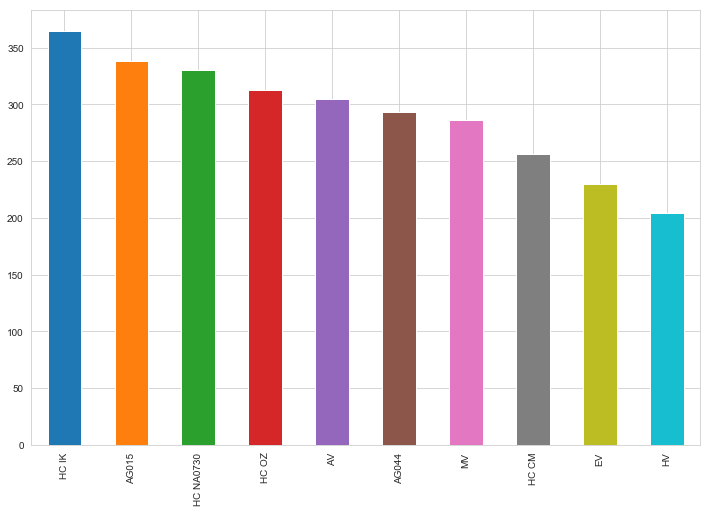

In [60]:
df_gfer["Pcol"].value_counts().plot(kind='bar')

## Group by patient

In [61]:
df_gfer["GFER area ratio*"] = df_gfer['GFER total area']/df_gfer['Cell area']
df_gfer["GFER total intensity ratio*"] = df_gfer["GFER total intensity"]/df_gfer['Cell intensity']
df_gfer["GFER IxA ratio*"] = df_gfer["GFER IxA"]/df_gfer['Cell IxA']

In [62]:
df_grp_gfer_row = df_gfer.groupby("Pcol")
GFER_features = df_gfer.columns[df_gfer.columns.str.contains("GFER")].tolist()
GFER_features.remove('GFER count')
GFER_features.remove('GFER mean area')
GFER_features.remove('GFER mean intensity')

In [63]:
GFER_medians = df_grp_gfer_row[GFER_features].median()
display(GFER_medians)

GFER total intensity  GFER total area      GFER IxA  GFER area ratio*  GFER total intensity ratio*  GFER IxA ratio*
Pcol                                                                                                                          
AG015               327633.6020         268.7140  1.989059e+06          0.098610                    84.427276         0.188822
AG044               410479.9050         307.2680  2.398699e+06          0.128706                    94.901693         0.226411
AV                  384727.5900         251.1800  1.969822e+06          0.091475                   101.662712         0.189028
EV                  352185.6995         196.0960  1.324487e+06          0.063250                    97.606538         0.110061
HC CM               417028.4815         331.7730  2.617466e+06          0.153166                    93.819650         0.300077
HC IK               436863.8840         225.9350  1.542416e+06          0.048091                   128.742125         0.103411
HC NA0730           583680.2335         139.2690  8.676449e+05          0.032648                   195.782772         0.075282
HC OZ               421892.5830         171.6430  1.077164e+06          0.048511                   135.827596         0.107590
HV                  504321.1625         245.5815  1.745885e+06          0.072472                   139.476061         0.146312
MV                  576548.1330          81.7020  5.810800e+05          0.021169                   185.544754         0.048100

In [64]:
plot_column(df_grp_gfer_row, 'GFER total area', agg='50%')

In [65]:
plot_column(df_grp_gfer_row, 'GFER area ratio*')

In [66]:
plot_column(df_grp_gfer_row, 'GFER IxA ratio*')

In [67]:
plot_column(df_grp_gfer_row, 'GFER total intensity')

In [68]:
plot_column(df_grp_gfer_row, 'GFER total intensity ratio*')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


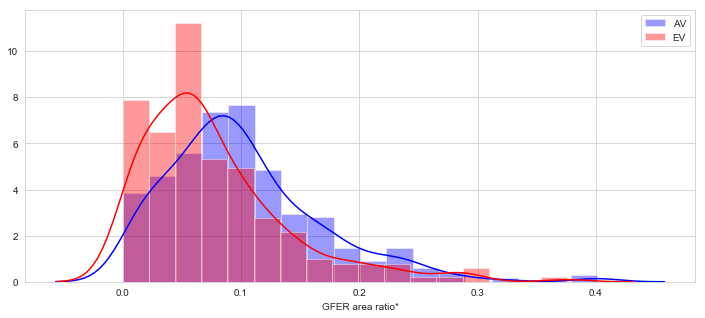

In [69]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

sns.distplot(df_grp_gfer_row["GFER area ratio*"].get_group('AV'), kde=True, ax=ax, color='b')
sns.distplot(df_grp_gfer_row["GFER area ratio*"].get_group('EV'), kde=True ,ax=ax, color='r')
ax.legend(['AV','EV'])

## GFER IxA ratio*

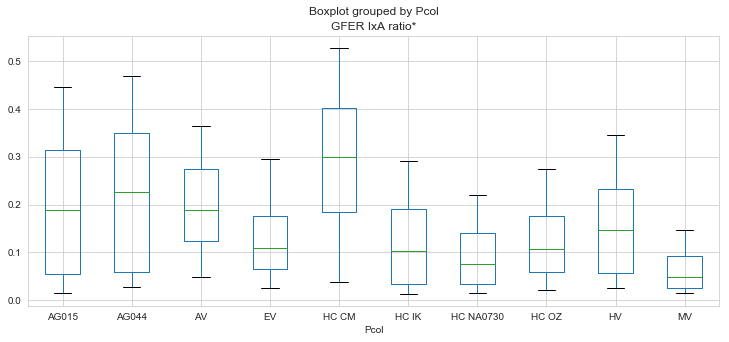

In [70]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="GFER IxA ratio*",by="Pcol", ax=ax, showfliers=False, whis=[10,90])
plt.show()

In [71]:
p_values = compare_results(df_gfer, 'AV', 'GFER IxA ratio*', hyp_alternative='less')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cell area - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cell area - adjusted p values:
----------------------------------------
AG015:		 1.000000
AG044:		 0.600212
EV:		 1.000000
HC CM:		 0.000000
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 1.000000
HV:		 1.000000
MV:		 1.000000


In [72]:
p_values = compare_results(df_gfer, 'EV', 'GFER IxA ratio*', hyp_alternative='less')
corrected_pval = pval_corrected(list(p_values.values()))
print("Cell area - adjusted p values:\n"+"-"*40)
for k,v in zip(p_values.keys(), corrected_pval):
    print(f'{k}:\t\t {v:.6f}')

Cell area - adjusted p values:
----------------------------------------
AG015:		 0.000003
AG044:		 0.000000
AV:		 0.000000
HC CM:		 0.000000
HC IK:		 1.000000
HC NA0730:		 1.000000
HC OZ:		 1.000000
HV:		 0.092503
MV:		 1.000000


<div class="alert alert-info" role="alert">
  Alon GFER IxA ratio* is not informative but Ella's GFER IxA ratio* is significantly lower then the rest of the children.
</div>

### Other measures

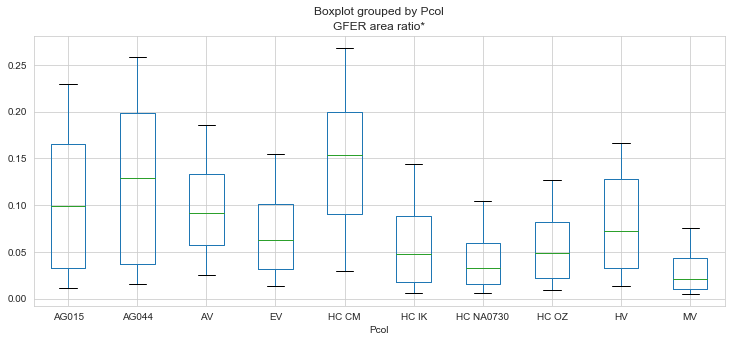

In [73]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="GFER area ratio*",by="Pcol", ax=ax, showfliers=False, whis=[10,90])
plt.show()

# Effecting Factors

## Age

### Cox17

In [74]:
df_cox17["Age_binned"]=pd.cut(df_cox17.age, [0,12*12*4,21*12*4,80*12*4], labels=['Child', 'Adolescent', 'Adult'])

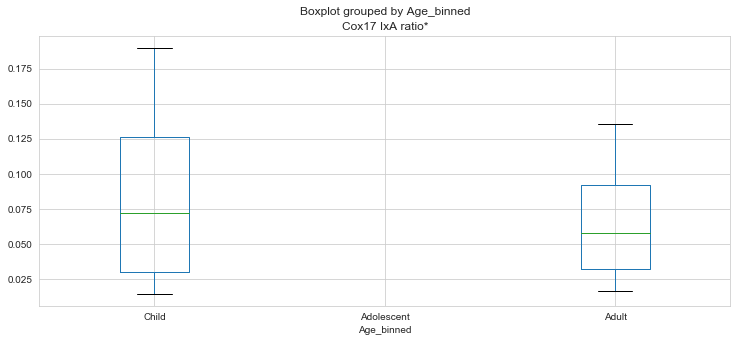

In [75]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 IxA ratio*",by="Age_binned", ax=ax, showfliers=False, whis=[10,90])
plt.show()

In [76]:
df_grp_age = df_cox17.groupby("Age_binned")
child_data = df_grp_age["Cox17 IxA ratio*"].get_group('Child')
adult_data = df_grp_age["Cox17 IxA ratio*"].get_group('Adult')
stat, p = mannwhitneyu(child_data, adult_data, alternative="greater")
print(f"p vlaue: {p:0.5f}")

p vlaue: 0.00000


### GFER

In [77]:
df_gfer["Age_binned"]=pd.cut(df_gfer.age, [0,12*12*4,21*12*4,80*12*4], labels=['Child', 'Adolescent', 'Adult'])

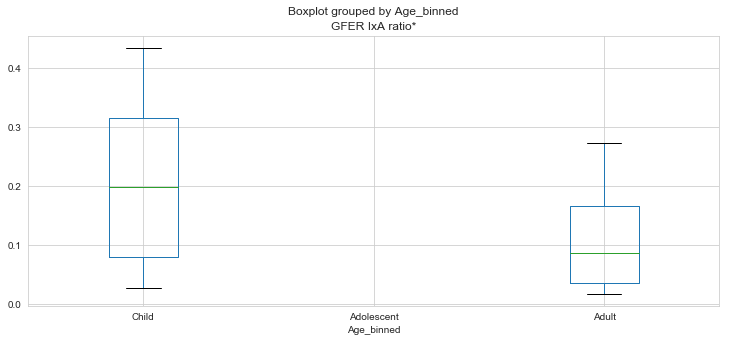

In [78]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="GFER IxA ratio*",by="Age_binned", ax=ax, showfliers=False, whis=[10,90])
plt.show()

In [79]:
df_grp_age = df_gfer.groupby("Age_binned")
child_data = df_grp_age["GFER IxA ratio*"].get_group('Child')
adult_data = df_grp_age["GFER IxA ratio*"].get_group('Adult')
stat, p = mannwhitneyu(child_data, adult_data, alternative="greater")
print(f"p vlaue: {p:0.5f}")

p vlaue: 0.00000


## Gender

### Cox17

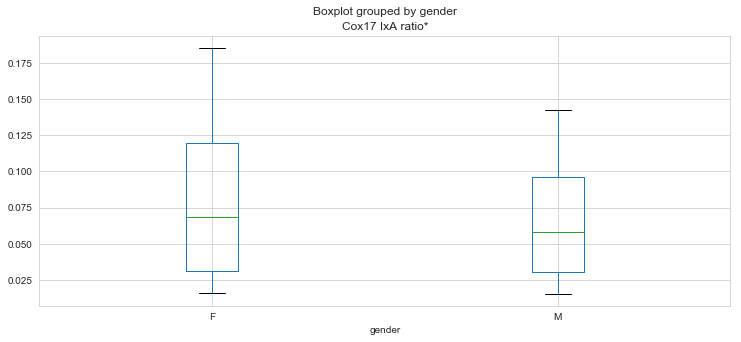

In [80]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_cox17.boxplot(column="Cox17 IxA ratio*",by="gender", ax=ax, showfliers=False, whis=[10,90])
plt.show()

In [81]:
female_data = df_cox17.loc[df_cox17.gender=="F","Cox17 IxA ratio*"]
male_data = df_cox17.loc[df_cox17.gender=="M","Cox17 IxA ratio*"]
stat, p = mannwhitneyu(female_data, male_data, alternative="greater")
print(f"p vlaue: {p:0.5f}")

p vlaue: 0.00000


### GFER

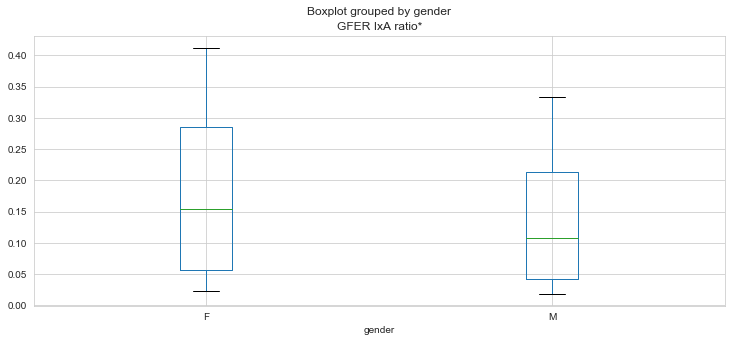

In [82]:
# Create a figure of given size
fig = plt.figure(figsize=(12,5))
# Add a subplot
ax = fig.add_subplot(111)

df_gfer.boxplot(column="GFER IxA ratio*",by="gender", ax=ax, showfliers=False, whis=[10,90])
plt.show()

In [83]:
female_data = df_gfer.loc[df_gfer.gender=="F","GFER IxA ratio*"]
male_data = df_gfer.loc[df_gfer.gender=="M","GFER IxA ratio*"]
stat, p = mannwhitneyu(female_data, male_data, alternative="greater")
print(f"p vlaue: {p:0.5f}")

p vlaue: 0.00000


## Conclusions
Female have more GFER and COX then Male   
Children have more GFER and COX then adults

# Data Comparisons
<div class="alert alert-warning" role="alert">
    NOTE: This section is still a <b>WORK IN PROGRESS</b> !!!
</div>
Cox17 and GFER are on the same plate and it should be possible to prove they are the same (assuming the different antibodies does not effect external parameters differently).  
Lets check inside each parameter for each person does the distribution is similar between "plates"


In [84]:
# Cox17 Cell area median
df_grp_row = df_cox17.groupby("Pcol")

plot_column(df_grp_row, 'Cell area')

In [85]:
# GFER Cell area median
plot_column(df_grp_gfer_row, 'Cell area')

The general pattern, by medians, look almost the same. Can this be translated into the by cell view?

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:2257: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


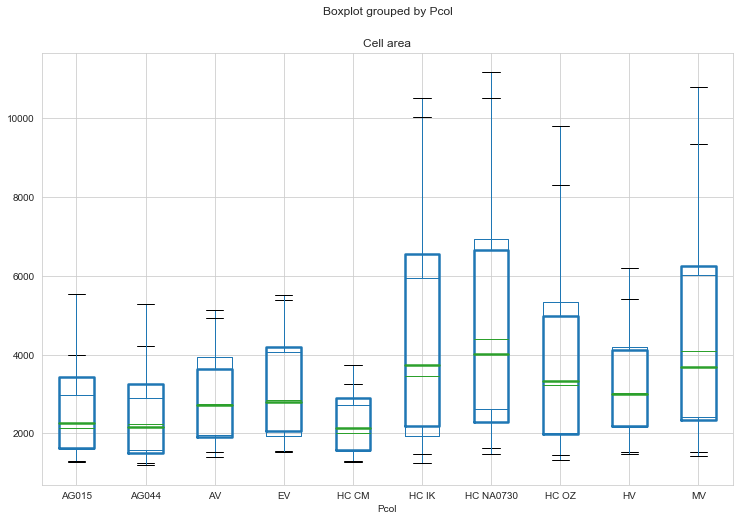

In [86]:
ax = df_cox17.boxplot(column="Cell area",by="Pcol", return_type='axes', showfliers=False, whis=[10,90])

boxprops = dict(linestyle='-', linewidth=2.5 )
medianprops = dict(linestyle='-', linewidth=2.5)
df_gfer.boxplot(column="Cell area",by="Pcol", ax=ax, boxprops=boxprops,medianprops=medianprops, showfliers=False, whis=[10,90] )
plt.show()

The bold lines belong to GFER while the other is Cox17.  
Normalization by one of the patients doesn't look good as for instance *HC IK* and *HC NA0730* differences are in opposite direction.

In [87]:
patients_names = df_cox17.Pcol.unique()
for patient in patients_names:
    stat, p = mannwhitneyu(df_cox17.loc[df_cox17.Pcol==patient, 'Cell area'], df_gfer.loc[df_gfer.Pcol==patient, 'Cell area'], alternative='two-sided')
    print(f"{patient}: {p:0.00}")

AV: 0.6
HC CM: 0.2
EV: 0.7
AG044: 0.7
HV: 0.6
AG015: 0.05
HC IK: 0.1
MV: 0.6
HC OZ: 0.8
HC NA0730: 0.3


The p value is 0.05 or above and there distributions cannot be considered as different but for some the distance is quite big.  
Maybe Kolmogorov-Smirnov test will help us? It have null hypothesis that 2 independent samples are drawn from the same continuous distribution.

In [88]:
from scipy import stats

patients_names = df_cox17.Pcol.unique()
for patient in patients_names:
    stat, p = stats.ks_2samp(df_cox17.loc[df_cox17.Pcol==patient, 'Cell area'], df_gfer.loc[df_gfer.Pcol==patient, 'Cell area'])
    print(f"{patient}: {p:0.00}")

AV: 0.4
HC CM: 0.5
EV: 0.6
AG044: 0.2
HV: 0.4
AG015: 0.04
HC IK: 0.3
MV: 0.3
HC OZ: 0.9
HC NA0730: 0.5


While not the same both test are quite consistent and put us in problem with AG015.  
Let's look at other variables.

In [89]:
data_comp_ks = pd.DataFrame()
for feature in df_cox17.columns:
    if feature not in df_gfer.columns:
        continue
    if feature in ['Target', "Cell cycle", "Toxicity status", "Cell status", "age", "gender", "color", "Pcol", "Prow", "Pfield", "Age_binned"]:
        continue
    for patient in patients_names:
        stat, p = stats.ks_2samp(df_cox17.loc[df_cox17.Pcol==patient, feature], df_gfer.loc[df_gfer.Pcol==patient, feature]) 
        data_comp_ks.loc[feature, patient] = p
data_comp_ks[data_comp_ks<1e-4] = 0
data_comp_ks

AV     HC CM        EV     AG044        HV     AG015     HC IK        MV     HC OZ  HC NA0730
Nuclear area           0.014649  0.377621  0.537551  0.890525  0.519651  0.357522  0.255866  0.000802  0.259855   0.986050
Nuclear perimeter      0.009608  0.856358  0.603872  0.300231  0.469801  0.560742  0.102361  0.003709  0.334097   0.413991
Nuclear IxA            0.000000  0.000000  0.022959  0.000000  0.000000  0.000000  0.133760  0.057801  0.000000   0.000000
Nuclear intensity      0.000000  0.000154  0.371188  0.000000  0.000000  0.751287  0.073641  0.517471  0.000000   0.034559
Nuclear 1/form factor  0.245857  0.152666  0.926753  0.115112  0.274032  0.238311  0.010074  0.231764  0.790859   0.505915
...                         ...       ...       ...       ...       ...       ...       ...       ...       ...        ...
Cell length            0.043920  0.170339  0.938351  0.000000  0.009150  0.000000  0.710345  0.000000  0.919679   0.550786
Cell perimeter         0.342089  0.674208  0.830745  0.000000  0.012988  0.000000  0.433000  0.000000  0.723356   0.157475
Cell 1/form factor     0.844820  0.876876  0.339300  0.000000  0.000519  0.000000  0.876356  0.000000  0.047935   0.390788
Cell intensity         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.974563  0.005618  0.804869   0.032879
Cell IxA               0.000000  0.000000  0.000000  0.015814  0.004773  0.000598  0.137778  0.356390  0.871083   0.910892

[11 rows x 10 columns]

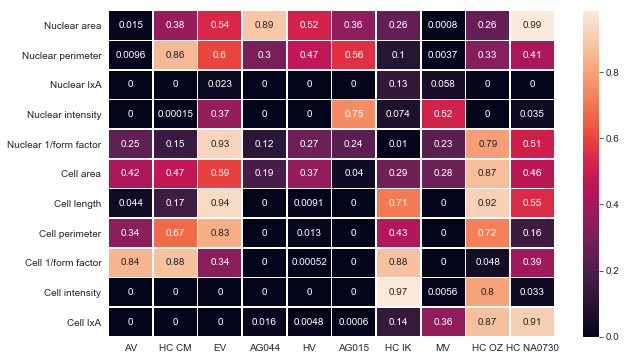

In [90]:
fig, ax = plt.subplots(figsize=(10,6)) 
sns.heatmap(data_comp_ks, linewidths=0.5, ax=ax, annot=True)

There is no row without black this means we cannot say the data came from the same distributions.  
Maybe a multiple comparison adjustment will help but I am not sure it fits here.  
Probably more data would had helped.  
Maybe alignment of the data would help?